<a href="https://colab.research.google.com/github/ericfelipemoreira/HECSummerSchoolAI/blob/main/02_dirty_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dirty categories: learning with non normalized strings

Including strings that represent categories often calls for much data
preparation. In particular categories may appear with many morphological
variants, when they have been manually input, or assembled from diverse
sources.

Including such a column in a learning pipeline as a standard categorical
colum leads to categories with very high cardinalities and can lose
information on which categories are similar.

Here we look at a dataset on wages [#]_ where the column *Employee
Position Title* contains dirty categories.

.. [#] https://catalog.data.gov/dataset/employee-salaries-2016

We investigate encodings to include such compare different categorical
encodings for the dirty column to predict the *Current Annual Salary*,
using gradient boosted trees. For this purpose, we use the skrub
library ( https://skrub-data.org ).


.. |SV| replace::
    :class:`~skrub.TableVectorizer`

.. |tabular_learner| replace::
    :func:`~skrub.tabular_learner`

.. |OneHotEncoder| replace::
    :class:`~sklearn.preprocessing.OneHotEncoder`

.. |RandomForestRegressor| replace::
    :class:`~sklearn.ensemble.RandomForestRegressor`

.. |SE| replace:: :class:`~skrub.SimilarityEncoder`

.. |GapEncoder| replace:: :class:`~skrub.GapEncoder`

.. |permutation importances| replace::
    :func:`~sklearn.inspection.permutation_importance`


## The data

### Data Importing and preprocessing

We first download the dataset:



In [3]:
%pip install skrub

In [4]:
from skrub.datasets import fetch_employee_salaries
employee_salaries = fetch_employee_salaries()
print(employee_salaries.description)

Annual salary information including gross pay and overtime pay for all active, permanent employees of Montgomery County, MD paid in calendar year 2016. This information will be published annually each year.


Then we load it:



In [5]:
import pandas as pd
df = employee_salaries.X.copy()
df

,gender,department,department_name,division,assignment_category,employee_position_title,date_first_hired,year_first_hired
0,F,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,09/22/1986,1986
1,M,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,09/12/1988,1988
2,F,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,11/19/1989,1989
3,M,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,05/05/2014,2014
4,M,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,03/05/2007,2007
...,...,...,...,...,...,...,...,...
9223,F,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,11/03/2015,2015
9224,F,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,11/28/1988,1988
9225,M,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,04/30/2001,2001
9226,M,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,09/05/2006,2006


Recover the target



In [6]:
y = employee_salaries.y

## A simple default as a learner

The function |tabular_learner| is a simple way of creating a default
learner for tabular_learner data:



In [7]:
from skrub import tabular_learner
model = tabular_learner("regressor")

We can quickly compute its cross-validation score using the
corresponding scikit-learn utility



In [8]:
from sklearn.model_selection import cross_validate
import numpy as np

results = cross_validate(model, df, y)
print(f"Prediction score: {np.mean(results['test_score'])}")
print(f"Training time: {np.mean(results['fit_time'])}")

Prediction score: 0.91126242677003
Training time: 5.878209209442138


Below the hood, `model` is a pipeline:



In [9]:
model

Pipeline(steps=[('tablevectorizer',
                 TableVectorizer(high_cardinality=MinHashEncoder(),
                                 low_cardinality=OrdinalEncoder())),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

We can see that it is made of first a |SV|, and an
HistGradientBoostingRegressor



## Understanding the vectorizer + learner pipeline

The number one difficulty is that our input is a complex and
heterogeneous dataframe:



In [10]:
df

,gender,department,department_name,division,assignment_category,employee_position_title,date_first_hired,year_first_hired
0,F,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,09/22/1986,1986
1,M,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,09/12/1988,1988
2,F,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,11/19/1989,1989
3,M,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,05/05/2014,2014
4,M,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,03/05/2007,2007
...,...,...,...,...,...,...,...,...
9223,F,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,11/03/2015,2015
9224,F,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,11/28/1988,1988
9225,M,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,04/30/2001,2001
9226,M,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,09/05/2006,2006


The |SV| is a transformer that turns this dataframe into a
form suited for machine learning.

Feeding it output to a powerful learner,
such as gradient boosted trees, gives **a machine-learning method that
can be readily applied to the dataframe**.



In [11]:
from skrub import TableVectorizer

### Assembling the pipeline




We use the |SV| with a HistGradientBoostingRegressor, which is a good
predictor for data with heterogeneous columns



In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

We then create a pipeline chaining our encoders to a learner



In [13]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    TableVectorizer(),
    HistGradientBoostingRegressor()
)
pipeline

Pipeline(steps=[('tablevectorizer', TableVectorizer()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor())])

Note that it is almost the same model as above (can you spot the
differences)

Let's perform a cross-validation to see how well this model predicts



In [14]:
results = cross_validate(pipeline, df, y)
print(f"Prediction score: {np.mean(results['test_score'])}")
print(f"Training time: {np.mean(results['fit_time'])}")

Prediction score: 0.9212243483861651
Training time: 12.134786653518677


The prediction perform here is pretty much as good as above
but the code here is much simpler as it does not involve specifying
columns manually.



### Analyzing the features created

Let us perform the same workflow, but without the `Pipeline`, so we can
analyze its mechanisms along the way.



In [15]:
tab_vec = TableVectorizer()

We split the data between train and test, and transform them:



In [16]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(
    df, y, test_size=0.15, random_state=42
)

X_train_enc = tab_vec.fit_transform(df_train, y_train)
X_test_enc = tab_vec.transform(df_test)

The encoded data, X_train_enc and X_test_enc are numerical arrays:



In [17]:
X_train_enc

,gender_F,gender_M,gender_nan,department_BOA,department_BOE,department_CAT,department_CCL,department_CEC,department_CEX,department_COR,...,"employee_position_title: captain, chief, battalion","employee_position_title: income, assistance, client","employee_position_title: planning, engineer, budget","employee_position_title: lieutenant, shift, commander","employee_position_title: sheriff, deputy, candidate",date_first_hired_year,date_first_hired_month,date_first_hired_day,date_first_hired_total_seconds,year_first_hired
4405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090986,0.203152,28.590433,0.076135,0.401093,2007.0,8.0,6.0,1.186358e+09,2007.0
5694,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051111,0.054571,0.052015,0.051193,0.057994,2005.0,8.0,8.0,1.123459e+09,2005.0
1516,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.453222,0.053435,15.844386,0.090738,0.050982,2009.0,4.0,27.0,1.240790e+09,2009.0
8960,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.068086,0.073551,0.081208,31.635765,1.992840,1997.0,2.0,3.0,8.549280e+08,1997.0
6108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.051961,0.054290,0.051400,0.052347,0.056869,2006.0,1.0,17.0,1.137456e+09,2006.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.079390,0.051283,0.051365,0.069113,0.051160,2005.0,5.0,16.0,1.116202e+09,2005.0
5191,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.401850,0.100512,1.305234,0.183549,0.073355,2001.0,8.0,6.0,9.970560e+08,2001.0
5390,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.050466,0.062374,0.066189,0.052503,0.076162,1990.0,5.0,31.0,6.441120e+08,1990.0
860,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057308,0.056175,0.056365,0.054840,0.069407,2012.0,11.0,5.0,1.352074e+09,2012.0


They have more columns than the original dataframe, but not much more:



In [18]:
X_train_enc.shape

(7843, 143)

#### Inspecting the features created

The |SV| assigns a transformer for each column. We can inspect this
choice:



In [19]:
tab_vec.transformers_

{'year_first_hired': PassThrough(),
 'date_first_hired': DatetimeEncoder(),
 'gender': OneHotEncoder(drop='if_binary', dtype='float32', handle_unknown='ignore',
               sparse_output=False),
 'department': OneHotEncoder(drop='if_binary', dtype='float32', handle_unknown='ignore',
               sparse_output=False),
 'department_name': OneHotEncoder(drop='if_binary', dtype='float32', handle_unknown='ignore',
               sparse_output=False),
 'assignment_category': OneHotEncoder(drop='if_binary', dtype='float32', handle_unknown='ignore',
               sparse_output=False),
 'division': GapEncoder(n_components=30),
 'employee_position_title': GapEncoder(n_components=30)}

This is what is being passed to transform the different columns under the hood.
We can notice it classified the columns "gender" and "assignment_category"
as low cardinality string variables.
A |OneHotEncoder| will be applied to these columns.

The vectorizer actually makes the difference between string variables
(data type ``object`` and ``string``) and categorical variables
(data type ``category``).

Next, we can have a look at the encoded feature names.

Before encoding:



In [20]:
df.columns.to_list()

['gender',
 'department',
 'department_name',
 'division',
 'assignment_category',
 'employee_position_title',
 'date_first_hired',
 'year_first_hired']

After encoding (we only plot the first 8 feature names):



In [21]:
feature_names = tab_vec.get_feature_names_out()
feature_names[:8]

array(['gender_F', 'gender_M', 'gender_nan', 'department_BOA',
       'department_BOE', 'department_CAT', 'department_CCL',
       'department_CEC'], dtype='<U70')

As we can see, it created a new column for each unique value.
This is because we used |SE| on the column "division",
which was classified as a high cardinality string variable.
(default values, see |SV|'s docstring).

In total, we have reasonnable number of encoded columns.



In [22]:
len(feature_names)

143

### Feature importance in the statistical model

Here we consider interpretability, plot the feature importances of a
classifier. We can do this because the |GapEncoder| leads to
interpretable features even with messy categories

.. topic:: Note:

   To minimize compute time, use the feature importances computed by the
   |RandomForestRegressor|, but you should prefer |permutation importances|
   instead (which are less subject to biases)

First, let's train the |RandomForestRegressor|,



In [23]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(X_train_enc, y_train)

RandomForestRegressor()

Retrieving the feature importances



In [24]:
importances = regressor.feature_importances_
std = np.std(
    [
        tree.feature_importances_
        for tree in regressor.estimators_
    ],
    axis=0
)
indices = np.argsort(importances)[::-1]

Plotting the results:



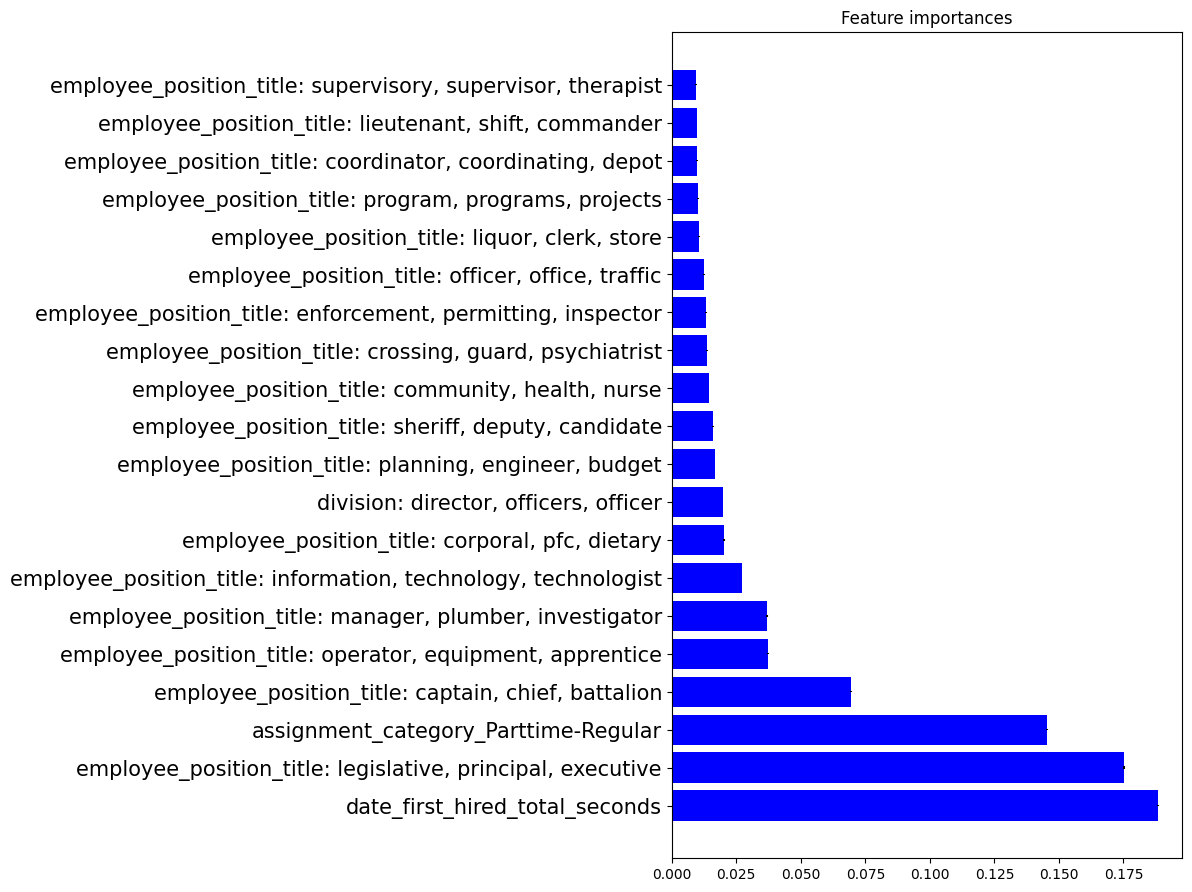

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

We can deduce from this data that the three factors that define the
most the salary are: being hired for a long time, being a manager, and
having a permanent, full-time job :).



## Exploring different machine-learning pipeline to encode the data

### The learning pipeline

To build a learning pipeline, we need to assemble encoders for each
column, and apply a supervised learning model on top.



#### Encoding the table

The TableVectorizer applies different transformations to the different
columns to turn them into numerical values suitable for learning



In [26]:
from skrub import TableVectorizer
encoder = TableVectorizer()

#### Pipelining an encoder with a learner

Here again we use a pipeline with HistGradientBoostingRegressor



In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor
pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())

The pipeline can be readily applied to the dataframe for prediction



In [28]:
pipeline.fit(df, y)

# The categorical encoders
# ........................
#
# A encoder is needed to turn a categorical column into a numerical
# representation
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

### Dirty-category encoding

The one-hot encoder is actually not well suited to the 'Employee
Position Title' column, as this columns contains 400 different entries.

We will now experiments with different encoders for dirty columns



In [50]:
!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 43.7 MB/s eta 0:00:00


In [54]:
import sklearn
from sklearn import preprocessing
from skrub import SimilarityEncoder, MinHashEncoder,\
    GapEncoder
from sklearn.preprocessing import TargetEncoder

ImportError: cannot import name 'TargetEncoder' from 'sklearn.preprocessing' (/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/__init__.py)

In [40]:

similarity = SimilarityEncoder()
target = TargetEncoder()
minhash = MinHashEncoder(n_components=100)
gap = GapEncoder(n_components=100)

encoders = {
    'one-hot': one_hot,
    'similarity': similarity,
    'target': target,
    'minhash': minhash,
    'gap': gap}

NameError: name 'TargetEncoder' is not defined

We now loop over the different encoding methods,
instantiate each time a new pipeline, fit it
and store the returned cross-validation score:



In [ ]:
all_scores = dict()

for name, method in encoders.items():
    encoder = TableVectorizer(high_cardinality=method)

    pipeline = make_pipeline(encoder, HistGradientBoostingRegressor())
    scores = cross_validate(pipeline, df, y)
    print('{} encoding'.format(name))
    print('r2 score:  mean: {:.3f}; std: {:.3f}'.format(
        np.mean(scores['test_score']), np.std(scores['test_score'])))
    print('time:  {:.3f}\n'.format(
        np.mean(scores['fit_time'])))
    all_scores[name] = scores['test_score']

Note that the time it takes to fit varies also a lot, and not only the
prediction score



#### Plotting the results
Finally, we plot the scores on a boxplot:



In [ ]:
import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
ax = seaborn.boxplot(data=pd.DataFrame(all_scores), orient='h')
plt.ylabel('Encoding', size=20)
plt.xlabel('Prediction accuracy     ', size=20)
plt.yticks(size=20)
plt.tight_layout()

The clear trend is that encoders that use the string form
of the category (similarity, minhash, and gap) perform better than
those that discard it.

SimilarityEncoder is the best performer, but it is less scalable on big
data than MinHashEncoder and GapEncoder. The most scalable encoder is
the MinHashEncoder. GapEncoder, on the other hand, has the benefit that
it provides interpretable features, as shown above

|


.. topic:: The TableVectorizer automates preprocessing

  As this notebook demonstrates, many preprocessing steps can be
  automated by the |SV|, and the resulting pipeline can still be
  inspected, even with non-normalized entries.


